# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#
from pyspark.sql.functions import to_timestamp

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load the data into spark df

data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# df.persist()

In [4]:
# explore the schema (which variables and their format)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Rows in the dataset
df.count()

286500

In [6]:
# convert ts to timedate
df = df.withColumn("ts", F.to_timestamp(F.col("ts")/1000))

In [7]:
# create new column from ts to have timestamps
df.select("ts").show(1, False)

+-------------------+
|ts                 |
+-------------------+
|2018-10-01 00:01:57|
+-------------------+
only showing top 1 row



In [8]:
# convert userId to integer
df = df.withColumn("userId", F.col("userId").cast('integer'))

In [9]:
# it might come in handy to have the categorical and numerical columns collected by lists
cat_cols = [col[0] for col in df.dtypes if col[1] == "string"]
num_cols = [col[0] for col in df.dtypes if col[1] != "string"]

print("Categorical columns: ")
print(cat_cols)
print("\n")
print("Numerical columns: ")
print(num_cols)

Categorical columns: 
['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent']


Numerical columns: 
['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts', 'userId']


In [10]:
# check for null values for each column
for col in df.columns:
    counts = df.filter(F.col(col).isNull()).count()
    if counts > 0:
        print(f"Null values in column [{col}]: {counts}")

Null values in column [artist]: 58392
Null values in column [firstName]: 8346
Null values in column [gender]: 8346
Null values in column [lastName]: 8346
Null values in column [length]: 58392
Null values in column [location]: 8346
Null values in column [registration]: 8346
Null values in column [song]: 58392
Null values in column [userAgent]: 8346
Null values in column [userId]: 8346


In [11]:
# i suggest to drop first the 8.346 null values that are present in most columsn. 
# There remain 50.046 nulls for artist, length and song. 
df_clean = df.dropna(how = "any", subset  = ["gender"])
df_clean.count()

278154

In [12]:
# remaining duplicates?
df_clean.dropDuplicates().count()

278154

In [13]:
# no duplicates
# show one specific line
df_clean.show(1, False)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------------+------------------------------------------------------------------------+------+
|artist        |auth     |firstName|gender|itemInSession|lastName|length   |level|location       |method|page    |registration |sessionId|song     |status|ts                 |userAgent                                                               |userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------------+------------------------------------------------------------------------+------+
|Martha Tilston|Logged In|Colin    |M     |50           |Freeman |277.89016|paid |Bakersfield, CA|PUT   |NextSong|1538173362000|29       |Rockpools|200   |2018-10-01 00:01:57|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/201001

In [14]:
# inspect page values
df_clean.groupBy(["page"]).count().show(truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [15]:
# inspect method values
df_clean.groupBy(["method"]).count().show(truncate=False)

+------+------+
|method|count |
+------+------+
|PUT   |257818|
|GET   |20336 |
+------+------+



In [16]:
# inspect level values
df_clean.groupBy(["level"]).count().show(truncate=False)

+-----+------+
|level|count |
+-----+------+
|free |55721 |
|paid |222433|
+-----+------+



In [17]:
# inspect level values
df_clean.groupBy(["auth"]).count().show(truncate=False)

+---------+------+
|auth     |count |
+---------+------+
|Cancelled|52    |
|Logged In|278102|
+---------+------+



In [18]:
# time period for cancellations:
max_date = df_clean.agg({"ts": "max"}).collect()[0][0]
min_date = df_clean.agg({"ts": "min"}).collect()[0][0]
print(f"First timestamp in dataset: {min_date}")
print(f"Last timestamp in dataset: {max_date}")
print(f"Time duration of dataset: {max_date-min_date}")

First timestamp in dataset: 2018-10-01 00:01:57
Last timestamp in dataset: 2018-12-03 01:11:16
Time duration of dataset: 63 days, 1:09:19


In [19]:
# get all user_id in the dataset as list
userId_all = [row.userId for row in df_clean.select("userId").dropDuplicates().collect()]
n_userId_all = len(userId_all)
print(f"Number of total users: {n_userId_all}")

Number of total users: 225


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
# add column churn. churn =1 if for all rows with a given userId, if that user did at one time cancel
userId_churned = df_clean.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
userId_churned = [(row['userId']) for row in userId_churned.collect()]
n_userId_churned = len(userId_churned)
print(f"Number of churned users: {n_userId_churned}")
df_clean = df_clean.withColumn("churn", F.when(F.col("userId").isin(userId_churned), 1).otherwise(0))

Number of churned users: 52


In [21]:
# anything special concerning the time period
max_date = df_clean.where(df_clean["churn"] == 1).agg({"ts": "max"}).collect()[0][0]
min_date = df_clean.where(df_clean["churn"] == 1).agg({"ts": "min"}).collect()[0][0]
print(f"First timestamp in dataset: {min_date}")
print(f"Last timestamp in dataset: {max_date}")
print(f"Time duration of dataset: {max_date-min_date}")

First timestamp in dataset: 2018-10-01 00:32:10
Last timestamp in dataset: 2018-11-29 11:45:09
Time duration of dataset: 59 days, 11:12:59


In [22]:
# do the same for users who downgrade
userId_downgrade = df_clean.filter(F.col("page").isin(["Submit Downgrade", "Downgrade"])).select("userId").dropDuplicates()
userId_downgrade = [(row['userId']) for row in userId_downgrade.collect()]
n_userId_downgrade = len(userId_downgrade)
print(f"Number of downgraded users: {n_userId_downgrade}")
df_clean = df_clean.withColumn("downgrade", F.when(F.col("userId").isin(userId_downgrade), 1).otherwise(0))

Number of downgraded users: 154


In [23]:
# anything special concerning the time period
max_date = df_clean.where(df_clean["downgrade"] == 1).agg({"ts": "max"}).collect()[0][0]
min_date = df_clean.where(df_clean["downgrade"] == 1).agg({"ts": "min"}).collect()[0][0]
print(f"First timestamp in dataset: {min_date}")
print(f"Last timestamp in dataset: {max_date}")
print(f"Time duration of dataset: {max_date-min_date}")

First timestamp in dataset: 2018-10-01 00:01:57
Last timestamp in dataset: 2018-12-03 01:11:16
Time duration of dataset: 63 days, 1:09:19


In [24]:
# # define a basic plot function for reuse
# def plotAB(df, hew, x, rot=0, normalize = False):    
#     # Group the data by x and y columns and calculate the count
#     df_plot = df.dropDuplicates(["userId", hew]).groupby([hew, x]).count().sort(hew).toPandas()

#     # Create the bar plot using seaborn
#     sns.barplot(x=x, y='count', hue=hew, data=df_plot)
#     plt.xticks(rotation=rot)

#     # Add labels and title
#     plt.xlabel(x.capitalize())
#     plt.ylabel("Count")
#     plt.title(f"Count by {x.capitalize()} and {hew.capitalize()}")

#     # Modify the legend
#     plt.legend(title=hew.capitalize(), loc='best')

#     # Show the plot
#     plt.show()

# define a basic plot function for reuse
def plotAB(df, hew, x, rot=0, normalize=False):    
    # Group the data by x and y columns and calculate the count
    df_plot = df.dropDuplicates(["userId", hew]).groupby([hew, x]).count().sort(hew).toPandas()

    # Create the bar plot using seaborn
    sns.barplot(x=x, y='count', hue=hew, data=df_plot)
    plt.xticks(rotation=rot)

    # Add labels and title
    plt.xlabel(x.capitalize())
    plt.ylabel("Count")
    plt.title(f"Count by {x.capitalize()} and {hew.capitalize()}")

    # Modify the legend
    plt.legend(title=hew.capitalize(), loc='best')

    # Add numbers on top of the bars
    for p in plt.gca().patches:
        plt.gca().annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    # Show the plot
    plt.show()

Distribution of UserIds across gender and churn

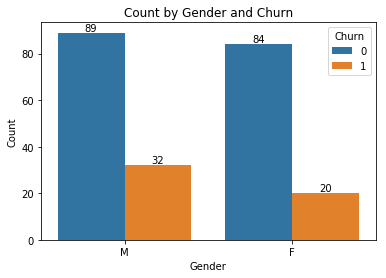

In [25]:
plotAB(df_clean, 'churn', 'gender')

Distribution of UserIds across gender and downgrade

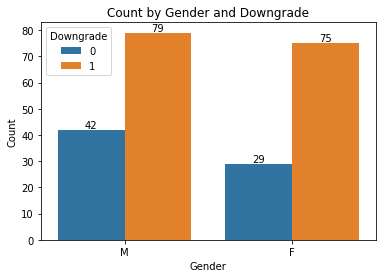

In [26]:
plotAB(df_clean, 'downgrade', 'gender')

Distribution of UserIds across level and churn

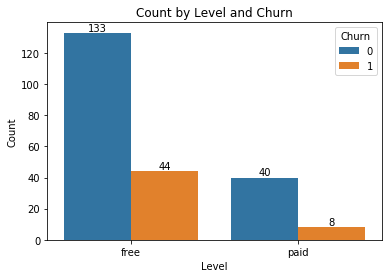

In [27]:
plotAB(df_clean, 'churn', 'level')

Distribution of UserIds across level and downgrade

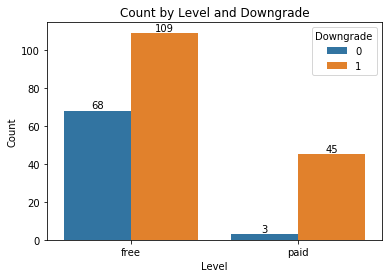

In [28]:
plotAB(df_clean, 'downgrade', 'level')

How many users who did downgrade did also churn?

In [29]:
df_clean.where((F.col("downgrade")==1) & (F.col("churn")==1)).select("userId").distinct().count()

35

How many users who did not downgrade did also not churn?

In [30]:
df_clean.where((F.col("downgrade")==0) & (F.col("churn")==0)).select("userId").distinct().count()

54

Relative distribution of page interactions across churn

In [31]:
df_plot = df_clean.filter((F.col("churn") == 1) & (F.col("page") != "NextSong")).groupby(["page"]).count()
df_plot = df_plot.withColumn("freq_churn", F.col("count") / n_userId_churned)

df_tmp = df_clean.filter((F.col("churn") == 0) & (F.col("page") != "NextSong")).groupby(["page"]).count()
df_tmp = df_tmp.withColumn("freq_no_churn", F.col("count") / (n_userId_all - n_userId_churned))

df_plot = df_plot.join(df_tmp, "page", "outer").sort("freq_no_churn").toPandas().fillna(0)

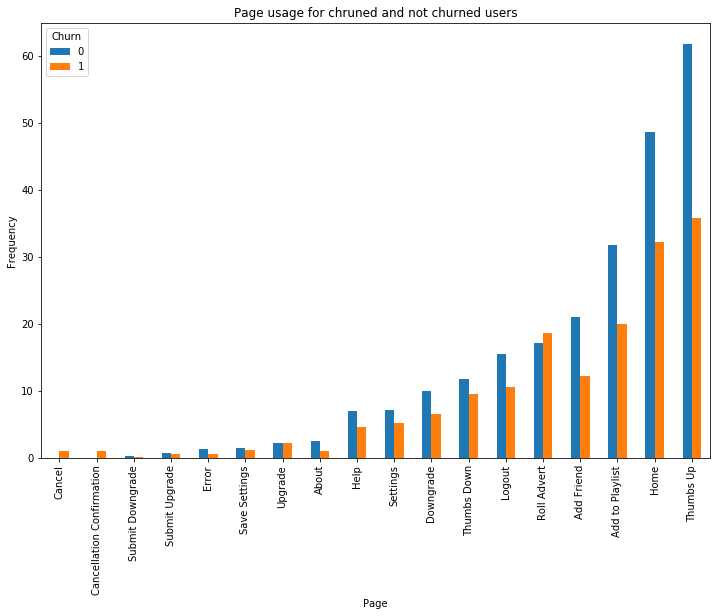

In [32]:
df_plot.plot(x='page', y=['freq_no_churn', 'freq_churn'], kind='bar', figsize=(12,8))
plt.xlabel('Page')
plt.ylabel('Frequency')
plt.title('Page usage for chruned and not churned users')
plt.legend(['0', '1'], title="Churn", loc='best')
plt.show()

Number of songs in the dataset

In [33]:
df_clean.select("song").distinct().count()

58481

How many distinct songs does a churned or not churned user hear?

In [34]:
df_plot = df_clean.groupBy('userId').agg(F.countDistinct('song').alias('distinct_songs_count')).withColumn("churn", F.when(F.col("userId").isin(userId_churned), 1).otherwise(0))

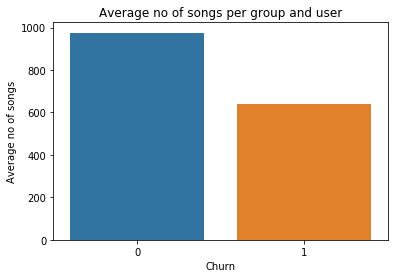

In [35]:
data = df_plot.groupBy("churn").agg(F.avg("distinct_songs_count").alias('Average_no_songs')).toPandas()

# Create the bar plot using seaborn
sns.barplot(x="churn", y='Average_no_songs', data=data)

# Add labels and title
plt.xlabel("Churn")
plt.ylabel("Average no of songs")
plt.title(f"Average no of songs per group and user")

# Show the plot
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Some features we would like to use:
- Gender of User
- Downgrade influence on Churn
- Songs per User
- Page Usage of User
- Level of User

First we will define the functions and test it on a subset of the data. Then we can just reuse the functions for the real show.

Lets start with some function to load, transform and clean the data:

In [144]:
def load_data(spark_session, data_path):
    """
        Loads a json file
    """
    return spark_session.read.json(data_path)

In [145]:
def sample_df(df, perc):
    """
        randomly pick perc of the data
    """
    return df.sample(fraction=perc/100, seed=42)

In [146]:
def drop_na(df):
    """
        Drop null values in gender, which is enough
    """
    return df.dropna(how = "any", subset  = ["gender"])

In [147]:
def convert_ts(df):
    """
        Converts unix time to timestamp
    """
    df_tmp = df.withColumn("ts", F.to_timestamp(F.col("ts")/1000))\
               .withColumn("registration", F.to_timestamp(F.col("registration")/1000))\
    
    return df_tmp

In [148]:
def convert_userid(df):
    """
        Converts userid to integer
    """
    return df.withColumn("userId", F.col("userId").cast('integer'))

Now let's go on with the functions to extract features. We will condense the information always to a numerical value per unique userId:

In [149]:
def set_churn_label(df):
    """
        Return a dataframe with unique userIds and either 0 (service not churned) or 1 (service churned) in the column "churn_service"
    """
    df_tmp = df.groupBy("userId")\
                   .agg(F.max(F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn_service"))

    return df_tmp

In [150]:
def set_downgrade_label(df):
    """
        Return a dataframe with unique userIds and either 0 (service not churned) or 1 (service churned) in the column "churn_service"
    """
    df_tmp = df.groupBy("userId")\
                   .agg(F.max(F.when(F.col("page") == "downgrade", 1).otherwise(0)).alias("churn_paid"))

    return df_tmp

In [151]:
def days_since_reg(df):
    """
    Add column for expired days since registration per user
    """
    df_tmp = df.groupBy("userId") \
               .agg(
                   (F.round((F.max("ts") - F.first("registration")) / 1000 / 60 / 60 / 24, 1)).alias("days_since_reg")
               )

    return df_tmp

In [152]:
def min_session_dur(df):
    """
        Add column with avg session duration per user
    """
    df_tmp = df.groupBy("userId", "sessionId")\
               .agg(
                   ((F.max("ts") - F.min("ts"))/1000/60).alias("delta_time"))\
               .groupBy("userId")\
               .agg(
                   F.round(F.avg("delta_time"),1).alias("min_session_dur")
    )
    return df_tmp

In [153]:
def cnt_songs_session(df):
    """
        Add column with avg number of songs per session
    """
    df_tmp = df.filter(F.col("page") == "NextSong")\
               .groupBy("userId", "sessionId")\
               .count()\
               .groupBy("userId").agg(F.avg("count").alias("cnt_songs_session"))
    
    return df_tmp

In [154]:
def gender(df):
    """
        Add column with 0 if Male, 1 if Female
    """
    df_tmp = df.select("userId", "gender").dropDuplicates() \
               .withColumn("gender", F.when(F.col("gender") == "M", 0).otherwise(1))
    
    return df_tmp

In [155]:
def level(df):
    """
        Add column with 0 if free, 1 if paid user at the last timestamp
    """
    window_spec = Window.partitionBy("userId").orderBy(F.col("ts").desc())
    
    df_tmp = df.withColumn("last_level", F.row_number().over(window_spec)) \
               .filter(F.col("last_level") == 1).select("userId", "level") \
               .withColumn("level", F.when(F.col("level") == "free", 0).otherwise(1))    
    
    return df_tmp

In [156]:
def page_freq(df):
    """
        For every relevant page status return the frequency of visits, so the relative count
    """    
    page_rel = [(row['page']) for row in df.select("page").dropDuplicates().collect()]
    page_rel.remove("Cancel")
    page_rel.remove("Cancellation Confirmation")    
    
    df_tmp = df.filter(F.col("page").isin(page_rel)) \
               .groupBy("userId").pivot("page", page_rel).agg(F.count("*")) \
               .fillna(0)

    df_tmp = df_tmp.withColumn("totalcount", sum(df_tmp[col] for col in df_tmp.columns[1:]))    
    
    for col in df_tmp.columns[1:-1]:
        df_tmp = df_tmp.withColumn(col, F.col(col) / F.col("totalcount"))

    # Drop the "totalcount" column
    df_tmp = df_tmp.drop("totalcount")    
    
    return df_tmp

In [157]:
def prepare_df(df):
    """
        Clean and format dataframe for further feature engineering
    """
    df = drop_na(df)
    df = convert_userid(df)
    
    return df

In [158]:
def feature_df(df):
    """
        Returns a df with unique userIds and columns that hold numeric values for the identified features
    """
    churn_df = set_churn_label(df)
    downgrade_df = set_downgrade_label(df)
    days_since_reg_df = days_since_reg(df)
    min_session_dur_df = min_session_dur(df)
    cnt_songs_session_df = cnt_songs_session(df)
    gender_df = gender(df)
    level_df = level(df)
    page_freq_df = page_freq(df)
    
    feature_df = churn_df.join(downgrade_df, "userId", "inner")\
                         .join(days_since_reg_df, "userId", "inner")\
                         .join(min_session_dur_df, "userId", "inner")\
                         .join(cnt_songs_session_df, "userId", "inner")\
                         .join(gender_df, "userId", "inner")\
                         .join(level_df, "userId", "inner")\
                         .join(page_freq_df, "userId", "inner")
    
    return feature_df

In [159]:
# loead the json dataset
df = load_data(spark, "mini_sparkify_event_data.json")

In [116]:
# get a sample of the dataframe: (df, percent)
df = sample_df(df, 5)

In [160]:
# clean the data
clean_df = prepare_df(df)

In [161]:
final_df = final_df(clean_df)

In [163]:
# replace " " with "_" in the column names for data storage
new_columns = [F.col(column).alias(column.replace(" ", "_")) for column in final_df.columns]
final_df = feature_df.select(*new_columns)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [ ]:
# save the final dataframe to parquet format for easier usage
# final_df.write.parquet("final_df.parquet")
# final_df.write.csv("final_df.csv")

# as just 1 parquet file
# Reduce the number of partitions to 1
final_df_single_partition = final_df.coalesce(1)

# Save the DataFrame as a single Parquet file
final_df_single_partition.write.parquet("final_df_signle.parquet")

In [3]:
# read the parquet file
final_df = spark.read.parquet("final_df_signle.parquet")
# final_df = spark.read.csv("final_df.csv")

In [4]:
# convert all columns to float except, drop userid
float_columns = [F.col(column).cast("float").alias(column) for column in final_df.columns[1:]]
final_df = final_df.select(*float_columns)

In [5]:
# split into train, test and validation sets
train, test, validation = final_df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [68]:
# # Scale the features
# assembler = VectorAssembler(inputCols=final_df.columns[1:], outputCol="unscaled_features")

# scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

# pipeline = Pipeline(stages=[assembler, scaler])

# scalerModel = pipeline.fit(train)

# train_sc  = scalerModel.transform(train)
# test_sc = scaler.transform(test)

In [6]:
# Gather the columns into one with a VectorAssembler
assembler = VectorAssembler(inputCols=final_df.columns[1:], outputCol="unscaled_features")

train_data = assembler.transform(train)
test_data = assembler.transform(test)
validation_data = assembler.transform(validation)



In [30]:
# Standardize the data using only the train sample
scaler = StandardScaler(
    inputCol="unscaled_features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

scalerModel = scaler.fit(train_data)
train_scaled = scalerModel.transform(train_data)
test_scaled = scalerModel.transform(test_data)
validation_scaled = scalerModel.transform(validation_data)

In [8]:
# Choose and implement several machine learning models.
rf = RandomForestClassifier(labelCol="churn_service", featuresCol="scaled_features")
lr = LogisticRegression(labelCol="churn_service", featuresCol="scaled_features")

In [24]:
# Train the models using the train and test sets.

# Random Forest
rf_model = rf.fit(train_scaled)
rf_predictions = rf_model.transform(test_scaled)

# Logistic Regression
lr_model = lr.fit(train_scaled)
lr_predictions = lr_model.transform(test_scaled)

In [25]:
#  evaluate models
evaluator = MulticlassClassificationEvaluator(labelCol="churn_service", predictionCol="prediction", metricName="f1")

rf_f1_score = evaluator.evaluate(rf_predictions)
lr_f1_score = evaluator.evaluate(lr_predictions)

In [26]:
# Tune the parameters of the models to improve their performance.
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Fit the models
cv_model = crossval.fit(train_scaled)
cv_predictions = cv_model.transform(test_scaled)
cv_f1_score = evaluator.evaluate(cv_predictions)

In [27]:
# save model locally for reuse
cv_model.write().overwrite().save('cv_model.model')

In [28]:
# load the model if necessary
cv_model = cv_model.load('cv_model.model')

In [29]:
# Select the winning model based on the F1 score.
best_model = cv_model.bestModel
print(best_model)

RandomForestClassificationModel (uid=RandomForestClassifier_1c0e810af814) with 30 trees


In [32]:
# Evaluate the winning model on the validation set.
validation_predictions = best_model.transform(validation_scaled)
validation_f1_score = evaluator.evaluate(validation_predictions)

In [33]:
# Print the results
print("Random Forest F1 Score:", rf_f1_score)
print("Logistic Regression F1 Score:", lr_f1_score)
print("Cross-Validated Random Forest F1 Score:", cv_f1_score)
print("Validation F1 Score:", validation_f1_score)

Random Forest F1 Score: 0.8467300489772399
Logistic Regression F1 Score: 0.7841390807335079
Cross-Validated Random Forest F1 Score: 0.8029386343993086
Validation F1 Score: 0.7499057315233785


The F1 score is a measure of a model's accuracy, taking into account both precision and recall. It is the harmonic mean of precision and recall. A higher F1 score indicates better performance, with a maximum value of 1.
In this case the F1 score of the Random Forest model achieved the best performance.

Cross-validation is a technique used to assess the performance of a model on unseen data by splitting the data into multiple subsets and training the model on different combinations of these subsets. The F1 score obtained through cross-validation provides an estimate of the model's performance on unseen data.
In this case the F1 score of the Cross-Validated Random Forest model indicates a relatively good performance, it is only slightly smaller than the original F1 score.

The Validation F1 score represents the performance of the model on a separate validation dataset that was not used during training or cross-validation. It provides an additional measure of the model's performance on unseen data.
In this case the Validation F1 score indicates a relatively good performance, it is in the range of the original F1 score.

In [38]:
# Which features have the highest importance with the RF model

# Get feature importances from the RandomForestClassifier model
feature_importances = rf_model.featureImportances

# Create a dictionary to store feature names and their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted features and their importances
for feature, importance in sorted_features:
    print(feature, ":", importance)

days_since_reg : 0.172604950854
NextSong : 0.102825044398
Thumbs_Down : 0.0965589363452
min_session_dur : 0.0636052025321
Roll_Advert : 0.0606471429117
Downgrade : 0.0530585456158
About : 0.0513437786273
Add_Friend : 0.0506845128354
Submit_Upgrade : 0.0482472143855
Thumbs_Up : 0.0456578871365
Logout : 0.0403364154292
Add_to_Playlist : 0.0370832449076
Help : 0.032735775861
cnt_songs_session : 0.0295231584475
Settings : 0.026412240876
Home : 0.0247561374206
Save_Settings : 0.022645718429
Error : 0.0160539443863
Submit_Downgrade : 0.0138946518502
Upgrade : 0.0113254967511
churn_paid : 0.0
gender : 0.0
level : 0.0


**Conclusion**

In this project, we aimed to predict customer churn for Sparkify, a music streaming service. We compared the performance and feature importance of two models, Logistic Regression (LR) and Random Forest (RF), to address this problem.

After evaluating the models, we found that the Random Forest model outperformed the Logistic Regression model in terms of F1 score. The Random Forest model achieved an F1 score of 0.847, while the Logistic Regression model achieved an F1 score of 0.784. This indicates that the Random Forest model is better at predicting customer churn for Sparkify.

When analyzing the feature importances, we observed that the important features differ between the LR and RF models. This can be attributed to the inherent differences in the algorithms and how they handle feature selection.

In the LR model, the top five features with the highest importance were 'min_session_dur', 'level', 'Downgrade', 'Thumbs_Down', and 'Roll_Advert'. It's important to note that the LR model considers both positive and negative coefficients as important features. Therefore, the feature 'cnt_songs_session' with a negative coefficient (-1.649) is indeed considered more important than 'level' with a positive coefficient (1.165).

On the other hand, the RF model identified 'days_since_reg', 'NextSong', 'Thumbs_Down', 'min_session_dur', and 'Roll_Advert' as the top five most important features. The RF model calculates feature importance based on the reduction in impurity achieved by each feature, which may result in different rankings compared to the LR model.

The differences in feature importance highlight the distinct strengths and biases of the LR and RF models. While 'cnt_songs_session' may have a negative impact on churn prediction according to the LR model, the RF model may assign higher importance to other features that contribute more to the overall predictive power.

To further improve the analysis, we could explore additional models or techniques, such as gradient boosting or neural networks, to see if they can achieve even better results. Additionally, gathering more data or incorporating more relevant features could potentially enhance the accuracy of the models.

Overall, this project provides valuable insights into customer churn prediction for Sparkify and demonstrates the importance of considering different models and their respective feature importance calculations when analyzing complex datasets.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.